In [1]:
## importing required libraries, we will go on importing in our notebook code as we require

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
!pip install tensorflow
!pip install keras
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from numpy import concatenate
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [60]:
def lstm_lag(n):
    data = pd.read_csv('converted.csv')
    data.drop(['Period'],axis=1,inplace=True)
    data = data.head(84*30)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    y = scaled_data[:,0]
    x = scaled_data[:,1:]

    pca = PCA(n_components=5)
    scaled_data = pca.fit_transform(scaled_data)

    x=n

    train_X = scaled_data[:(72-x)*30]
    train_y = y[x*30:72*30]
    test_X = scaled_data[(72-x)*30:(84-x)*30]
    test_y = y[(72-x)*30:(84-x)*30]

    train_X = train_X.reshape(train_X.shape[0],1,train_X.shape[1])
    test_X = test_X.reshape(test_X.shape[0],1,test_X.shape[1])

    model = Sequential()
    model.add(LSTM(128,activation='relu',return_sequences=True))
    #model.add(LSTM(64,return_sequences=True))
    model.add(LSTM(4))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(train_X, train_y, epochs=5, batch_size=30, validation_data=(test_X, test_y), verbose=0, shuffle=False)

    # plotting prediction results
    yhat = model.predict(test_X)
    # invert pca for forecast
    test_X1 = pca.inverse_transform(test_X.reshape((test_X.shape[0], test_X.shape[2])))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat.reshape(12*30,1), test_X1[:,1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    a = inv_yhat
    # invert scaling for actual
    test_y1 = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y1, test_X1[:,1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    b = inv_y
    
    pyplot.plot([inv_yhat[i*30] for i in range(12)], label='predicted')
    pyplot.plot([inv_y[i*30] for i in range(12)], label='actual')
    pyplot.scatter([i for i in range(12)],[inv_yhat[i*30] for i in range(12)])
    pyplot.scatter([i for i in range(12)],[inv_y[i*30] for i in range(12)])
    pyplot.xlabel('Month',fontsize=11)
    pyplot.ylabel('Inflation',fontsize=11)
    pyplot.legend()
    pyplot.show()
    
    print('mse = ',mean_squared_error(a,b))
    
    return mean_squared_error(a,b)

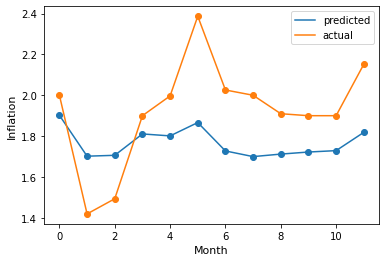

mse =  0.06920531380957408


0.06920531380957408

In [61]:
lstm_lag(0)

In [3]:
def svm_lag(n):
    data = pd.read_csv('converted.csv')
    data.drop(['Period'],axis=1,inplace=True)
    data = data.head(84*30)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    y = scaled_data[:,0]
    x = scaled_data[:,1:]

    pca = PCA(n_components=5)
    scaled_data = pca.fit_transform(scaled_data)

    x=n

    train_X = scaled_data[:(72-x)*30]
    train_y = y[x*30:72*30]
    test_X = scaled_data[(72-x)*30:(84-x)*30]
    test_y = y[(72-x)*30:(84-x)*30]

    para = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'tol' : [0.001,0.01,0.1],
    'C' : [0.1,0.5,1,2]
    }
    grid_ser = GridSearchCV(SVR(),scoring = 'neg_mean_squared_error',param_grid=para ,n_jobs =1,cv = 4,verbose=0)
    grid_ser.fit(train_X,train_y)

    a = scaler.inverse_transform(
    concatenate(
    (grid_ser.best_estimator_.predict(test_X).reshape(12*30,-1),pca.inverse_transform(test_X)[:,1:]),
     axis=1
    )
    )[:,0]

    b = scaler.inverse_transform(
    concatenate(
    (test_y.reshape(12*30,-1),pca.inverse_transform(test_X)[:,1:]),
     axis=1
    )
    )[:,0]

    pyplot.plot(a, label='predicted')
    pyplot.plot(b, label='actual')
    pyplot.legend()
    #pyplot.savefig('svm'+str(n)+'.png')
    pyplot.show()

    print('mse = ',mean_squared_error(a,b))
    #print('mae = ',mean_absolute_error(a,b))
    return mean_squared_error(a,b)

In [4]:
def regression_lag(n):
    data = pd.read_csv('converted.csv')
    data.drop(['Period'],axis=1,inplace=True)
    data = data.head(84*30)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    y = scaled_data[:,0]
    x = scaled_data[:,1:]

    pca = PCA(n_components=5)
    scaled_data = pca.fit_transform(scaled_data)

    x=n

    train_X = scaled_data[:(72-x)*30]
    train_y = y[x*30:72*30]
    test_X = scaled_data[(72-x)*30:(84-x)*30]
    test_y = y[(72-x)*30:(84-x)*30]

    para = {
    'n_jobs':[1,5,10,50]
    }
    grid_ser = GridSearchCV(LinearRegression(),scoring = 'neg_mean_squared_error',param_grid=para ,n_jobs =1,cv = 4,verbose=0)
    grid_ser.fit(train_X,train_y)

    a = scaler.inverse_transform(
    concatenate(
    (grid_ser.best_estimator_.predict(test_X).reshape(12*30,-1),pca.inverse_transform(test_X)[:,1:]),
     axis=1
    )
    )[:,0]

    b = scaler.inverse_transform(
    concatenate(
    (test_y.reshape(12*30,-1),pca.inverse_transform(test_X)[:,1:]),
     axis=1
    )
    )[:,0]

    pyplot.plot(a, label='predicted')
    pyplot.plot(b, label='actual')
    pyplot.legend()
    #pyplot.savefig('svm'+str(n)+'.png')
    pyplot.show()

    print('mse = ',mean_squared_error(a,b))
    #print('mae = ',mean_absolute_error(a,b))
    return mean_squared_error(a,b)

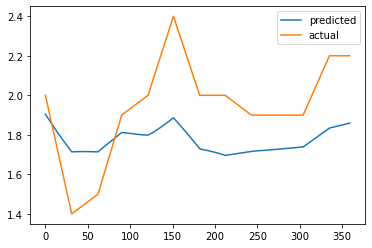

mse =  0.0680756207312909


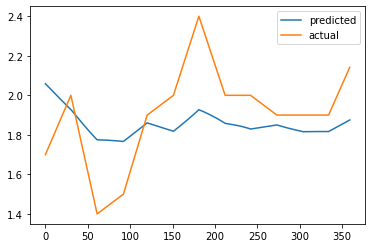

mse =  0.04326404067962159


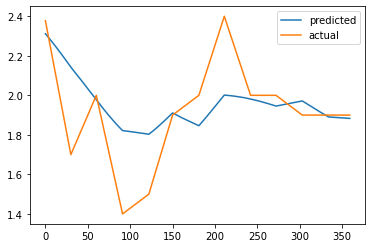

mse =  0.041167177762272335


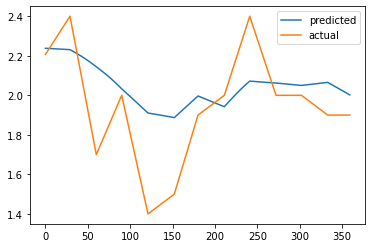

mse =  0.05070556320128006


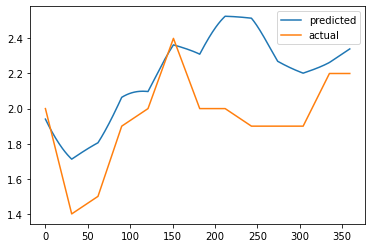

mse =  0.09802040863772415


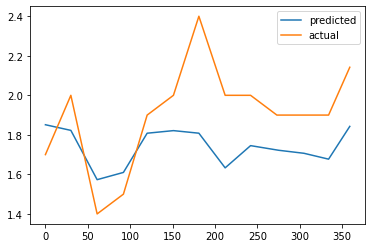

mse =  0.0626444373992385


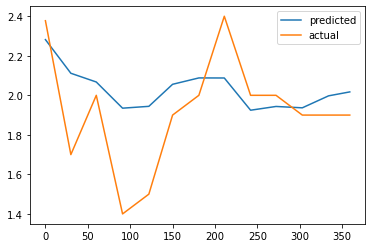

mse =  0.05588878392188159


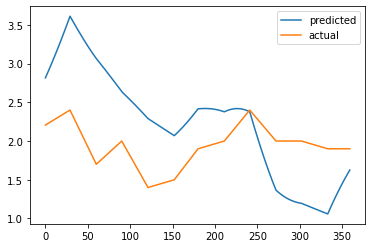

mse =  0.580463795846484


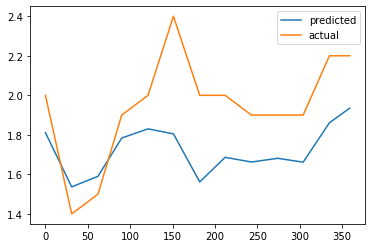

mse =  0.08141389735137354


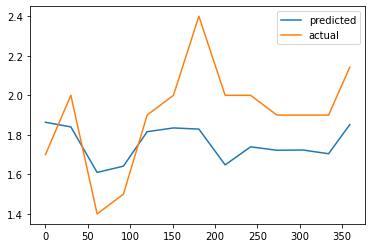

mse =  0.05931774043227917


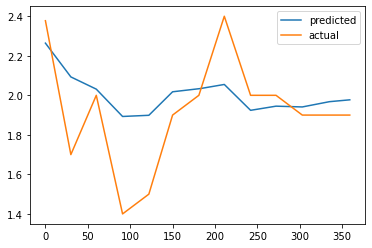

mse =  0.04739863119293623


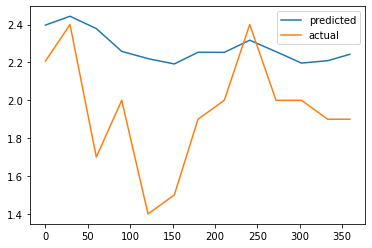

mse =  0.16215206513623528


,0,1,2,3
lstm,0.068076,0.043264,0.041167,0.050706
svm,0.098020,0.062644,0.055889,0.580464
regression,0.081414,0.059318,0.047399,0.162152


In [5]:
score_1 = [lstm_lag(i) for i in range(4)]
score_2 = [svm_lag(i) for i in range(4)]
score_3 = [regression_lag(i) for i in range(4)]

pd.DataFrame([score_1,score_2,score_3],index=['lstm','svm','regression'])

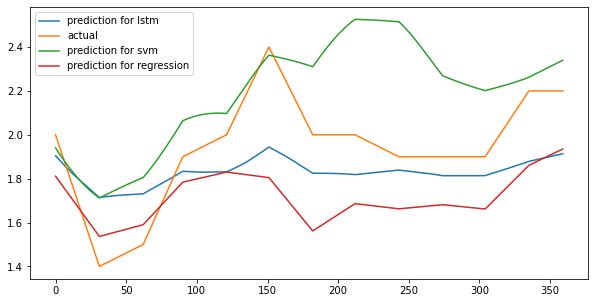

In [10]:
data = pd.read_csv('converted.csv')
data.drop(['Period'],axis=1,inplace=True)
data = data.head(84*30)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
y = scaled_data[:,0]
x = scaled_data[:,1:]

pca = PCA(n_components=5)
scaled_data = pca.fit_transform(scaled_data)

x=0

train_X = scaled_data[:(72-x)*30]
train_y = y[x*30:72*30]
test_X = scaled_data[(72-x)*30:(84-x)*30]
test_y = y[(72-x)*30:(84-x)*30]

train_X = train_X.reshape(train_X.shape[0],1,train_X.shape[1])
test_X = test_X.reshape(test_X.shape[0],1,test_X.shape[1])

model = Sequential()
model.add(LSTM(128,activation='relu',return_sequences=True))
#model.add(LSTM(64,return_sequences=True))
model.add(LSTM(4))
model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_X, train_y, epochs=5, batch_size=30, validation_data=(test_X, test_y), verbose=0, shuffle=False)

# plotting prediction results
yhat = model.predict(test_X)
# invert pca for forecast
test_X1 = pca.inverse_transform(test_X.reshape((test_X.shape[0], test_X.shape[2])))
# invert scaling for forecast
inv_yhat = concatenate((yhat.reshape(12*30,1), test_X1[:,1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
a = inv_yhat
# invert scaling for actual
test_y1 = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y1, test_X1[:,1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
b = inv_y
pyplot.figure(figsize=(10,5))
pyplot.plot(a,label='prediction for lstm')
pyplot.plot(b,label='actual')

train_X = scaled_data[:(72-x)*30]
train_y = y[x*30:72*30]
test_X = scaled_data[(72-x)*30:(84-x)*30]
test_y = y[(72-x)*30:(84-x)*30]

para = {
'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
'tol' : [0.001,0.01,0.1],
'C' : [0.1,0.5,1,2]
}
grid_ser = GridSearchCV(SVR(),scoring = 'neg_mean_squared_error',param_grid=para ,n_jobs =1,cv = 4,verbose=0)
grid_ser.fit(train_X,train_y)

a = scaler.inverse_transform(
concatenate(
(grid_ser.best_estimator_.predict(test_X).reshape(12*30,-1),pca.inverse_transform(test_X)[:,1:]),
 axis=1
)
)[:,0]

b = scaler.inverse_transform(
concatenate(
(test_y.reshape(12*30,-1),pca.inverse_transform(test_X)[:,1:]),
 axis=1
)
)[:,0]
pyplot.plot(a,label='prediction for svm')


train_X = scaled_data[:(72-x)*30]
train_y = y[x*30:72*30]
test_X = scaled_data[(72-x)*30:(84-x)*30]
test_y = y[(72-x)*30:(84-x)*30]
para = {
'n_jobs':[1,5,10,50]
}
grid_ser = GridSearchCV(LinearRegression(),scoring = 'neg_mean_squared_error',param_grid=para ,n_jobs =1,cv = 4,verbose=0)
grid_ser.fit(train_X,train_y)

a = scaler.inverse_transform(
concatenate(
(grid_ser.best_estimator_.predict(test_X).reshape(12*30,-1),pca.inverse_transform(test_X)[:,1:]),
 axis=1
)
)[:,0]
pyplot.plot(a,label='prediction for regression')
pyplot.legend()
pyplot.show()

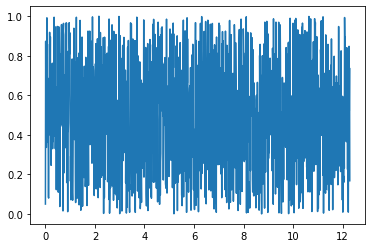

In [19]:
import pylab as pl
import numpy as np

period = 0.01
data = np.random.rand(1230)
t = np.arange(0, len(data)*period, period)
pl.plot(t, data)
pl.show()